In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from utils_local.misc import amro2title, amro2cute
import matplotlib.ticker as mtick


In [2]:
def empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv"):
    amro_prev_df = pd.read_csv(path_to_prev)
    gammas       = amro_prev_df[amro_prev_df.amro==amro][["prevalence_mean1", "prevalence_mean2", "prevalence_mean3"]].values / 100
    return np.squeeze(gammas)

In [3]:
amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

posterior_df = pd.DataFrame()

for amro in amro_search:
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")

    gammas        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_gamma, gamma in enumerate(gammas):
        # original model
        path_to_original_samples = os.path.join(path_to_save, "infer_building",
                                        "individual_observation", f"prevalence{idx_gamma}")

        # model that keep tracks of people status in the community
        path_to_readmission_samples = os.path.join(path_to_save, "infer_building",
                                        "individual_observation", f"prevalence{idx_gamma}", "readmissions")

        inference              = np.load(os.path.join(path_to_original_samples, f"{str(0).zfill(3)}posterior.npz"))
        inference_readmissions = np.load(os.path.join(path_to_readmission_samples, f"{str(1).zfill(3)}posterior.npz"))

        ## original model
        θpost  = inference["posterior"]
        Nif    = θpost.shape[-1]
        m      = θpost.shape[1]
        ρ_post = θpost[0, :, :, :].mean(-2).flatten()
        β_post = θpost[1, :, :, :].mean(-2).flatten()

        post_df                = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter", "model"])
        post_df["value"]       = np.concatenate([ρ_post, β_post])
        post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
        post_df["if_iter"]  = flatten_list([list(range(Nif)) * m  ] * 2 )
        post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( m )] * 2)
        post_df["gamma"]    = gamma
        post_df["amro"]     = amro
        post_df["model"]    = "original"
        posterior_df        = pd.concat([posterior_df, post_df])


        ## include readmissions
        θpost  = inference_readmissions["posterior"]
        Nif    = θpost.shape[-1]
        m      = 200#θpost.shape[1]
        ρ_post = θpost[0, :200, :, :].mean(-2).flatten()
        β_post = θpost[1, :200, :, :].mean(-2).flatten()

        post_df                = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter", "model"])
        post_df["value"]       = np.concatenate([ρ_post, β_post])
        post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
        post_df["if_iter"]  = flatten_list([list(range(Nif)) * m  ] * 2 )
        post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( m )] * 2)
        post_df["gamma"]    = gamma
        post_df["amro"]     = amro
        post_df["model"]    = "readmissions"
        posterior_df        = pd.concat([posterior_df, post_df])

v_df = posterior_df[posterior_df["if_iter"] == Nif-1]


In [4]:
from diagnostic_plots import convergence_plot
from utils_local import plot_utils
import seaborn as sns

COLORS_GAMMA = ["#ff5e5b", "#00cecb", "mediumpurple"]
CMAPS_GAMMA  = ["Reds", "Blues", "Purples"]


amro_plot_df = pd.DataFrame()
for amro in amro_search:
    amro_df                = v_df[v_df.amro==amro]
    amro_df                = amro_df[amro_df.model=="original"]

    gammas                 = amro_df["gamma"].unique()
    amro2level             = {gammas[2]: "low", gammas[1]: "medium",  gammas[0]: "high"}
    amro_df["gamma_level"] = amro_df["gamma"].map(amro2level)

    amro_df["gamma"]       = amro_df["gamma"].map(lambda x: "{:0.1f}%".format(x*100))
    amro_df["value"]       = amro_df.apply(lambda x: x["value"] * 100 if x["param"] == "ρ" else x["value"], axis=1)
    amro_q_df              = amro_df.groupby(["param", "gamma", "gamma_level"]).quantile(q=[1-0.05, 0.05]).reset_index().rename(columns={"level_3": "stat"}).replace( {1-0.05: "high95", 0.05: "low95"})
    amro_df                = amro_df.groupby(["param", "gamma", "gamma_level"]).mean()[["value"]].reset_index()
    amro_q_df["amro"]      = amro
    amro_df["amro"]        = amro
    amro_df["stat"]        = "mean"
    amro_plot_df           = pd.concat([amro_plot_df, amro_df, amro_q_df[list(amro_df.columns)]])

amro_plot_df["model"] = "original"

amro_plot_readm_df = pd.DataFrame()
for amro in amro_search:
    amro_df                = v_df[v_df.amro==amro]
    amro_df                = amro_df[amro_df.model=="readmissions"]

    gammas                 = amro_df["gamma"].unique()
    amro2level             = {gammas[2]: "low", gammas[1]: "medium",  gammas[0]: "high"}
    amro_df["gamma_level"] = amro_df["gamma"].map(amro2level)

    amro_df["gamma"]       = amro_df["gamma"].map(lambda x: "{:0.1f}%".format(x*100))
    amro_df["value"]       = amro_df.apply(lambda x: x["value"] * 100 if x["param"] == "ρ" else x["value"], axis=1)
    amro_q_df              = amro_df.groupby(["param", "gamma", "gamma_level"]).quantile(q=[1-0.05, 0.05]).reset_index().rename(columns={"level_3": "stat"}).replace( {1-0.05: "high95", 0.05: "low95"})
    amro_df                = amro_df.groupby(["param", "gamma", "gamma_level"]).mean()[["value"]].reset_index()
    amro_q_df["amro"]      = amro
    amro_df["amro"]        = amro
    amro_df["stat"]        = "mean"
    amro_plot_readm_df     = pd.concat([amro_plot_readm_df, amro_df, amro_q_df[list(amro_df.columns)]])
amro_plot_readm_df["model"] = "readmissions"

amro_plot_df = pd.concat([amro_plot_df, amro_plot_readm_df])

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_17094/1319432498.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_q_df              = amro_df.groupby(["param", "gamma", "gamma_level"]).quantile(q=[1-0.05, 0.05]).reset_index().rename(columns={"level_3": "stat"}).replace( {1-0.05: "high95", 0.05: "low95"})
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_17094/1319432498.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df                = amro_df.groupby(["param", "gamma", "gamma_level"]).mean()[["value"]].reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_17094/2398713852.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([amro2title(amro) for amro in amro_search], style='italic')


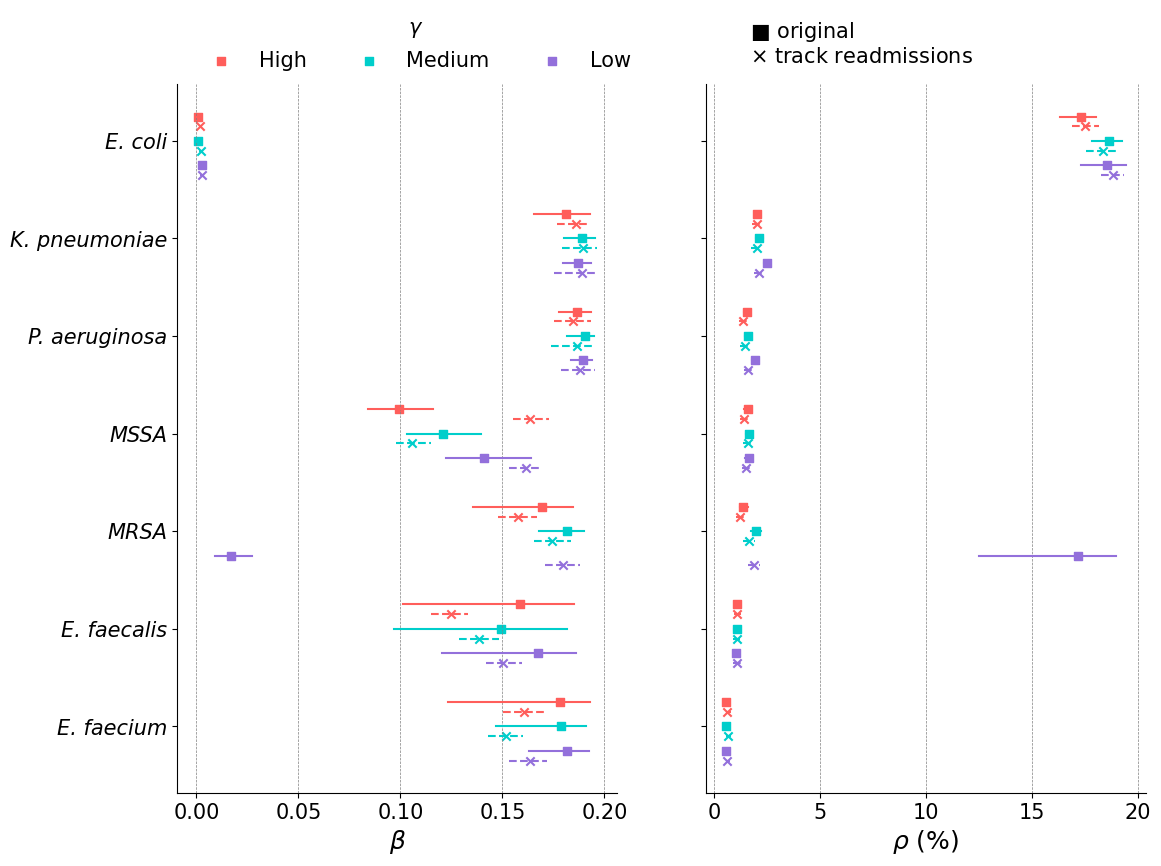

In [5]:
step = 2
ypos = np.flip(np.arange(0, len(amro_search) * step, step))


fig, ax = plt.subplots(1, 2, figsize=(12.5, 9.2), sharey=True)
for idx_gamma, gamma_level in  enumerate(["high", "medium", "low"]):

    β_upp  = amro_plot_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='high95' & model=='original'")["value"].values
    β_low  = amro_plot_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='low95' & model=='original'")["value"].values

    β_mean = amro_plot_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='mean' & model=='original'")["value"].values

    ax[0].scatter(x = β_mean,
                    y = ypos + step/4 * (2-idx_gamma),
                    c = COLORS_GAMMA[idx_gamma],
                    label  = gamma_level.capitalize(),
                    marker = "s")

    ax[0].plot(np.concatenate([[β_low], [β_upp]]),
               np.concatenate([[ypos], [ypos]]) + step/4 * (2-idx_gamma),
                color = COLORS_GAMMA[idx_gamma])

    ρ_upp  = amro_plot_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='high95' & model=='original'")["value"].values
    ρ_low  = amro_plot_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='low95' & model=='original'")["value"].values
    ρ_mean = amro_plot_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='mean' & model=='original'")["value"].values

    ax[1].scatter(x = ρ_mean,
                  y = ypos + step/4 * (2-idx_gamma),
                  c = COLORS_GAMMA[idx_gamma],
                  marker = "s")

    ax[1].plot(np.concatenate([[ρ_low], [ρ_upp]]),
               np.concatenate([[ypos], [ypos]]) + step/4 * (2-idx_gamma),
               color = COLORS_GAMMA[idx_gamma])

    #### include readmissions

    β_upp  = amro_plot_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='high95' & model=='readmissions'")["value"].values
    β_low  = amro_plot_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='low95' & model=='readmissions'")["value"].values
    β_mean = amro_plot_df.query(f"param=='β' & gamma_level=='{gamma_level}' & stat=='mean' & model=='readmissions'")["value"].values

    ax[0].scatter(x      = β_mean,
                  y      = ypos-0.2 + step/4 * (2-idx_gamma),
                  c      = COLORS_GAMMA[idx_gamma],
                  marker = "x")
                  #label  = gamma_level.capitalize())
    ax[0].plot(np.concatenate([[β_low], [β_upp]]),
               np.concatenate([[ypos-0.2], [ypos-0.2]]) + step/4 * (2-idx_gamma),
                color = COLORS_GAMMA[idx_gamma],
                ls    = "--")

    ρ_upp  = amro_plot_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='high95' & model=='readmissions'")["value"].values
    ρ_low  = amro_plot_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='low95' & model=='readmissions'")["value"].values
    ρ_mean = amro_plot_df.query(f"param=='ρ' & gamma_level=='{gamma_level}' & stat=='mean' & model=='readmissions'")["value"].values

    ax[1].scatter(x = ρ_mean,
                  y = ypos-0.2 + step/4 * (2-idx_gamma),
                  c = COLORS_GAMMA[idx_gamma],
                  marker = "x")

    ax[1].plot(np.concatenate([[ρ_low], [ρ_upp]]),
               np.concatenate([[ypos-0.2], [ypos-0.2]]) + step/4 * (2-idx_gamma),
                color = COLORS_GAMMA[idx_gamma],
                ls    = "--")

for axi in ax.flatten():
    axi.grid(axis='x', color='grey', linestyle='--', linewidth=0.5)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.legend().remove()

ax[0].text(1.3, 1.03, r"$\blacksquare$ original"+"\n"+r"$\times$ track readmissions", transform=ax[0].transAxes, ha="left")

ax[0].legend(bbox_to_anchor=(0.01, 1.12), title=r"$\gamma$", loc="upper left", frameon=False, ncol=3)
ax[0].set_yticklabels([amro2title(amro) for amro in amro_search], style='italic')
ax[0].set_yticks(ypos + step/4)

ax[1].set_xlabel(r"$\rho$ (%)")
ax[0].set_xlabel(r"$\beta$")

#fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures", "MarginalPosteriorEstimates_figS10.png"),
#                                                                    dpi=300, transparent=True, bbox_inches = 'tight')

fig.savefig(os.path.join(results2_dir, "paper_figures", "si_figures_corrected", "ReadmissionsVSOriginal_figS12.png"),
                                                                    dpi=300, transparent=True, bbox_inches = 'tight')


In [6]:
path_to_save_fig = os.path.join(results2_dir, "amro_inferences", "abm", "figures")

def add_subplot_axes(ax, rect, axisbg='w'):
    fig    = plt.gcf()
    box    = ax.get_position()
    height = box.height
    width  = box.width

    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure    = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)
    x              = infig_position[0]
    y              = infig_position[1]
    width         *= rect[2]
    height        *= rect[3]

    subax       = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)

    return subax


rect1      = (0.15,  0.16,
                0.45,  0.45)
rect2      = (0.5,   0.08,
                0.45, 0.45)
rect3      = (0.5,   0.08,
                0.45, 0.45)
rect4      = (0.5,   0.08,
                0.45, 0.45)
rect6      = (0.5,   0.08,
                0.45, 0.45)
rect7      = (0.5,   0.08,
                0.45, 0.45)
rect8      = (0.5,   0.08,
                0.45, 0.45)

rect  = [rect1, rect2, rect3, rect4, None, rect7, rect8]


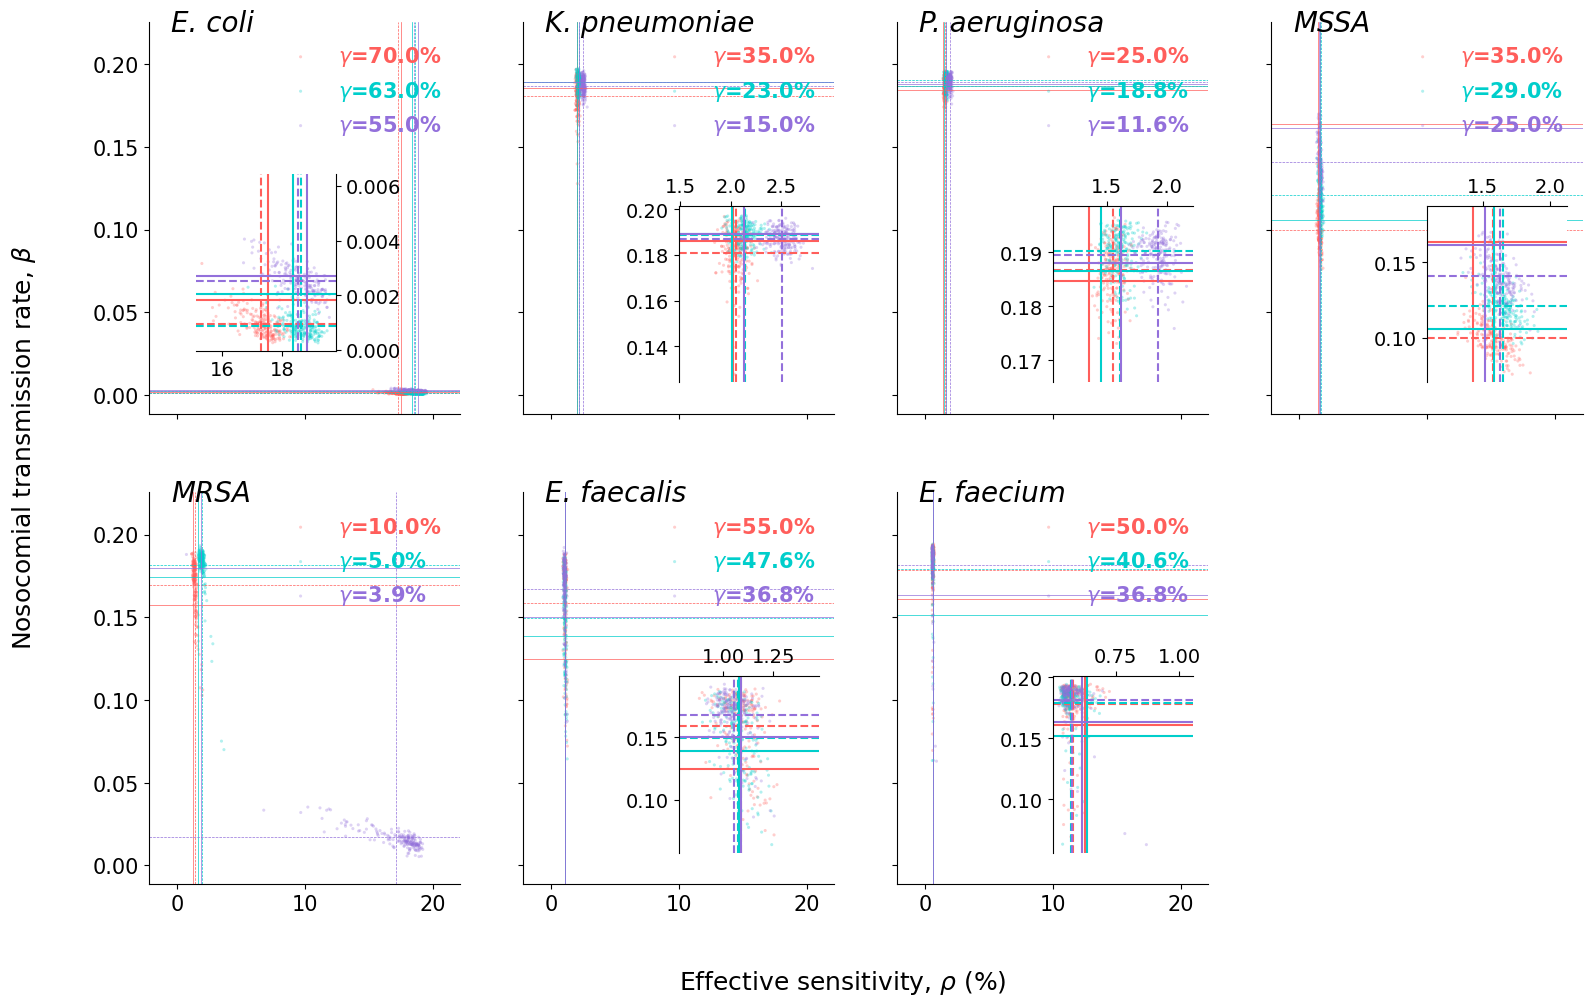

In [7]:
from diagnostic_plots import convergence_plot
from utils_local import plot_utils
import seaborn as sns

COLORS_GAMMA = ["#ff5e5b", "#00cecb", "mediumpurple"]
CMAPS_GAMMA  = ["Reds", "Blues", "Purples"]
v_df = posterior_df[posterior_df["if_iter"] == Nif-1]

fig, ax = plt.subplots(2, 4, figsize=(18.5, 11.2), sharex=True, sharey=True)

ax[-1, -1].remove()

for idx_axi, axi in enumerate(ax.flatten()[:-1]):
    amro    = amro_search[idx_axi]
    amro_df = v_df[v_df.amro==amro]
    gammas  = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_g, gamma in enumerate(gammas):
        rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ' and model=='original'")
        beta_df = amro_df.query(f"gamma=={gamma} and param=='β' and model=='original'")
        #sns.kdeplot(ax    = axi,
        #            x     = rho_df["value"].values * 100,
        #            y     = beta_df["value"].values,
        #            cmap  = CMAPS_GAMMA[idx_g],
        #            fill  = True,
        #            alpha = 0.7)

        ### original model
        axi.scatter(rho_df["value"].values * 100,
                    beta_df["value"].values,
                    fc        = COLORS_GAMMA[idx_g],
                    ec        = None,
                    alpha     = 0.3,
                    s         = 5,
                    label     = r"$\gamma$="+"{:0.1f}%".format(gamma*100))
        axi.axhline(y     = np.mean(beta_df["value"].values),
                    ls    = "--",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])
        axi.axvline(x     = np.mean(rho_df["value"].values*100),
                    ls    = "--",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])

        ### model that keep track of readmissions
        rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ' and model=='readmissions'")
        beta_df = amro_df.query(f"gamma=={gamma} and param=='β' and model=='readmissions'")
        axi.scatter(rho_df["value"].values * 100,
                    beta_df["value"].values,
                    fc        = COLORS_GAMMA[idx_g],
                    ec        = None,
                    alpha     = 0.3,
                    s         = 5,
                    marker    = "x",)
        axi.axhline(y     = np.mean(beta_df["value"].values),
                    ls    = "-",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])
        axi.axvline(x     = np.mean(rho_df["value"].values*100),
                    ls    = "-",
                    lw    = 0.5,
                    color = COLORS_GAMMA[idx_g])

    axi.set_ylim((-0.011310953055567037, 0.2257557217477729))
    axi.set_xlim((-2.2376656192686055, 22.171308067653385))

    axi.text(x       = -0.5,
            y        = 0.22,
            s        = f"{amro2title(amro)}",
            style    = 'italic',
            weight   = 'normal',
            color    = "k",
            fontsize = 20)

    l = axi.legend(loc             = "upper right",
                    frameon        = False,
                    prop           = {"weight": 'bold'},
                    bbox_to_anchor = [1, 0.99])

    for idx_t, text in enumerate(l.get_texts()):
        text.set_color(COLORS_GAMMA[idx_t])

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)

    if idx_axi != 4:
        ax_zoomed          = add_subplot_axes(axi, rect[idx_axi], axisbg='w')

        for idx_g, gamma in enumerate(gammas):
            rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ' and model=='original'")
            beta_df = amro_df.query(f"gamma=={gamma} and param=='β' and model=='original'")
            #sns.kdeplot(ax     = ax_zoomed,
            #            x      = rho_df["value"].values * 100,
            #            y      = beta_df["value"].values,
            #            cmap   = CMAPS_GAMMA[idx_g],
            #            fill   = True,
            #            alpha  = 0.8)

            # original model
            ax_zoomed.scatter(rho_df["value"].values * 100,
                                beta_df["value"].values,
                                fc        = COLORS_GAMMA[idx_g],
                                ec        = None,
                                alpha     = 0.3,
                                s         = 5,
                                label     = r"$\gamma$="+"{:0.1f}%".format(gamma*100))
            ax_zoomed.axhline(y       = np.mean(beta_df["value"].values),
                                ls    = "--",
                                color = COLORS_GAMMA[idx_g])

            ax_zoomed.axvline(x   = np.mean(rho_df["value"].values*100),
                                ls    = "--",
                                color = COLORS_GAMMA[idx_g])

            # readmission model
            rho_df  = amro_df.query(f"gamma=={gamma} and param=='ρ' and model=='readmissions'")
            beta_df = amro_df.query(f"gamma=={gamma} and param=='β' and model=='readmissions'")

            ax_zoomed.scatter(rho_df["value"].values * 100,
                                beta_df["value"].values,
                                fc        = COLORS_GAMMA[idx_g],
                                ec        = None,
                                alpha     = 0.3,
                                s         = 5,
                                marker    = "x")
            ax_zoomed.axhline(y       = np.mean(beta_df["value"].values),
                                ls    = "-",
                                color = COLORS_GAMMA[idx_g])

            ax_zoomed.axvline(x   = np.mean(rho_df["value"].values*100),
                                ls    = "-",
                                color = COLORS_GAMMA[idx_g])


            ax_zoomed.tick_params(axis = 'both',
                                    labelsize = 14)

            if idx_axi!=0:
                ax_zoomed.spines['bottom'].set_visible(False)
                ax_zoomed.spines['right'].set_visible(False)
                ax_zoomed.xaxis.set_label_position('top')
                ax_zoomed.xaxis.tick_top()
            else:
                ax_zoomed.spines['left'].set_visible(False)
                ax_zoomed.spines['top'].set_visible(False)
                ax_zoomed.yaxis.set_label_position('right')
                ax_zoomed.yaxis.tick_right()


fig.supxlabel(r'Effective sensitivity, $\rho$ (%)')
fig.supylabel(r'Nosocomial transmission rate, $\beta$', x=0.05)

#fig.savefig(os.path.join(results2_dir, "paper_figures", "fig3.png"),
#                                            dpi=300, transparent=True)
fig.savefig(os.path.join(results2_dir, "paper_figures_corrected", "fig3_OriginalVsReadmission.png"),
                                            dpi=300, transparent=True)


# simulate the inference assuming dependent readmissions

In [8]:
class Patient:
    susceptible = 0
    colonized   = 1

class Observed:
    no  = 0
    yes = 1

def amr_abm_readmissions(t, agents_state, gamma, beta, alpha, movement, ward2size, model_settings):
    """ Agent based model tracking colonized and susceptible patients with pre-defined movement patterns.

    Args:
        agents_state : agent state. {0: Patient.susceptible, 1: Patient.colonized}  Size: (n_patients)
        movement     : pd.Dataframe with patient locations and culture information.
        parameters   : dictionary of parameters, contains importation rate (gamma), nosocomial transmission rate (beta),
                        effective sensitivity (ro), and decolonization rate (alpha)
    """

    n  = model_settings["n"] # number of patients
    m  = model_settings["m"] # number of ensembles

    p_update = agents_state.copy()
    p_update = Patient.susceptible * (agents_state * np.random.random(size=(n, m)) <= alpha)

    new_patients = movement[movement["first_day"]==1]["mrn_id"].values

    if new_patients.shape[0] > 0:
        already_colonized         = p_update[new_patients, :]
        # if a patient was colonized on a previous admission we keep the colonization status
        p_update[new_patients, :] = Patient.colonized * (np.random.random(size=(new_patients.shape[0], m)) <= gamma) + already_colonized

    p_update = np.clip(p_update, 0, 1) # clip those possible 'recolonized' upon readmission.

    for i, ward_id in enumerate(movement["ward_id"].unique()):
        patients_ward = movement[movement["ward_id"]==ward_id]["mrn_id"].values
        λ_i = beta * np.sum(p_update[patients_ward, :]==Patient.colonized) / ward2size[ward_id]
        p_update[patients_ward, :] = p_update[patients_ward, :] + Patient.colonized * (np.random.random(size=(patients_ward.shape[0], m)) <= λ_i)
    p_update = np.clip(p_update, 0, 1)
    return p_update


def simulate_abm(f, f0, g, θ, model_settings):
    dates_simulation = model_settings["dates_simulation"]
    x                     = f0(θ)
    observations          = np.full((len(dates_simulation), model_settings["k"], model_settings["m"]), np.nan)
    observations[0, :, :] = g(0, x, θ)

    for t, date in enumerate(dates_simulation[1:]):
        x                       = f(t, x, θ)
        observations[t+1, :, :] = g(t, x, θ)
    return observations

def create_obs_infer(obs_sim, idx_infer, dates, model_settings, resample="W-Sun"):
    # obs_sim \in R^{[k x T x m]} as required by pompjax
    infer_df = pd.DataFrame(index=dates)
    for i in range(model_settings["k"]) :
        infer_df['y'+str(i+1)]   = obs_sim[i, :, idx_infer]
        infer_df['oev'+str(i+1)] = 1 +(0.2 * infer_df['y'+str(i+1)].values)**2
    infer_df                     = infer_df.resample(resample).sum()
    infer_df.index.values[-1]    = model_settings["dates"][-1]
    return infer_df

In [9]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
ward2buildingid        = {row.ward: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_17094/1190376738.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [10]:
from data_utils import create_obs_building_amro
from infer_utils import run_amro_inference


from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
model_settings   = {
                    "m"                 : 300,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0


amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_amro = os.path.join(data_db_dir, "long_files_8_25_2021", "amro_ward.csv" )
id_run       = 1



In [11]:
for amro in amro_search:
    gammas       = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")
    obs_df       = create_obs_building_amro(amro, model_settings, ward2buildingid, path_to_amro)
    path_to_save = os.path.join(results2_dir, "amro_inferences", "abm", f"{amro2cute(amro)}")
    for idx_gamma, gamma in enumerate(gammas):

        path_to_samples = os.path.join(path_to_save, "infer_building", "individual_observation", f"prevalence{idx_gamma}", "readmissions")

        inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

        if os.path.isfile(os.path.join(path_to_samples,  f"{str(id_run).zfill(3)}sim_post.npz")):
            continue

        alpha = 1/120
        f0    = lambda θ:       amr_abm_readmissions(t = 0,
                                                        agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)
        f       = lambda t, x, θ: amr_abm_readmissions(t = t,
                                                        agents_state   = x,
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)

        g = lambda t, x, θ: observe_cluster_individual(t = t,
                                                        agents_state   = x,
                                                        rho            = θ[0, :],
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                        model_settings = model_settings)

        θ    = inference["posterior"].mean(-2)[:, :, -1]

        ysim = simulate_abm(f, f0, g, θ, model_settings)
        np.savez_compressed(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}sim_post.npz"),
                                        y         = ysim,
                                        posterior = θ,
                                        gamma     = gamma)


/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop/Shaman-lab/AMR_ABM2/abm/data_utils.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df               = amro_df.groupby(["date", "buildingid"]).sum().unstack([1]).resample(resample).sum().stack().reset_index()
/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop/Shaman-lab/AMR_ABM2/abm/data_utils.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amro_df               = amro_df.groupby(["date", "buildingid"]).sum().unstack([1]).resample(resample).sum().stack().reset_index()
/Users/chaosdonkey06/Dropbox/My Mac (J

In [12]:
from matplotlib import dates as mdates
from utils import create_df_response
from utils_local import plot_utils

def format_axis(ax, week=False):
    ax.tick_params(which='both', axis='x', labelrotation=90)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    if week:
        ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

id2building    = {v: k for k, v in building2id.items()}
id2building[5] = "Rest"